In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

/tmp/ipython-input-2628453973.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  trades = pd.read_csv("historical_data.csv")


In [5]:
print(f"Sentiment shape: {sentiment.shape} | Trader dataset shape: {trades.shape}")
print(f"Missing Values (Trades):\n{trades.isnull().sum()}")

Sentiment shape: (2644, 4) | Trader dataset shape: (41760, 17)
Missing Values (Trades):
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           1
date                1
dtype: int64


In [6]:
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms')
trades['date'] = trades['Timestamp'].dt.date

In [7]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

In [8]:
trades['is_win'] = trades['Closed PnL'] > 0

In [9]:
trades['is_long'] = trades['Side'].str.upper().str.contains('LONG|BUY')

daily_metrics = trades.groupby(['Account', 'date']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    trades_per_day=('Trade ID', 'count'),
    avg_trade_size=('Size USD', 'mean'),
    win_rate=('is_win', 'mean'),
    long_ratio=('is_long', 'mean')
).reset_index()

In [10]:
final_data = daily_metrics.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)
final_data.rename(columns={'classification': 'sentiment'}, inplace=True)

In [11]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

/tmp/ipython-input-3342793225.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


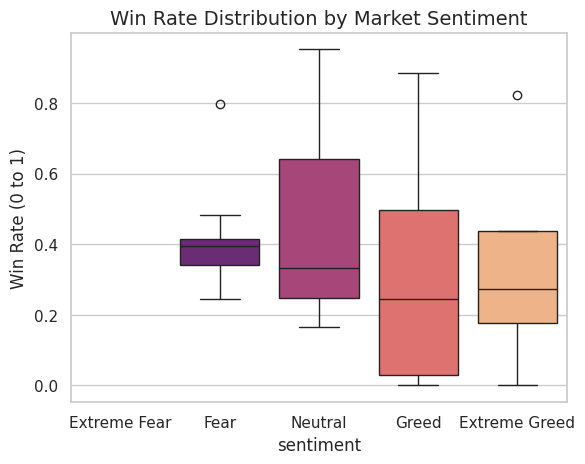

In [12]:
sns.boxplot(
    data=final_data.dropna(subset=['sentiment']),
    x='sentiment',
    y='win_rate',
    palette='magma',
    order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
)

plt.title('Win Rate Distribution by Market Sentiment', fontsize=14)
plt.ylabel('Win Rate (0 to 1)')
plt.show()

In [13]:
print("\n--- Final Merged Dataset Summary ---")
print(final_data[['date', 'daily_pnl', 'win_rate', 'sentiment']].head())


--- Final Merged Dataset Summary ---
         date     daily_pnl  win_rate      sentiment
0  2024-10-27 -3.275059e+05  0.025974          Greed
1  2025-02-19  1.927736e+06  0.405542           Fear
2  2024-10-27  1.610257e+04  0.216000          Greed
3  2025-02-19  1.834030e+05  0.244186           Fear
4  2024-03-09  0.000000e+00  0.000000  Extreme Greed


In [14]:
performance_summary = final_data.groupby('sentiment').agg(
    avg_daily_pnl=('daily_pnl', 'mean'),
    avg_win_rate=('win_rate', 'mean'),
    pnl_volatility=('daily_pnl', 'std'),
    sample_size=('date', 'count')
).reindex(['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])

In [15]:
behavior_summary = final_data.groupby('sentiment').agg(
    avg_trades_per_day=('trades_per_day', 'mean'),
    avg_position_size=('avg_trade_size', 'mean'),
    avg_long_bias=('long_ratio', 'mean')
).reindex(['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])

In [16]:
trader_profiles = final_data.groupby('Account').agg(
    total_pnl=('daily_pnl', 'sum'),
    avg_win_rate=('win_rate', 'mean'),
    avg_activity=('trades_per_day', 'mean')
).reset_index()

In [17]:
median_activity = trader_profiles['avg_activity'].median()
trader_profiles['frequency_segment'] = np.where(
    trader_profiles['avg_activity'] > median_activity, 'Frequent', 'Infrequent'
)

In [18]:
trader_profiles['performance_segment'] = np.where(
    (trader_profiles['total_pnl'] > 0) & (trader_profiles['avg_win_rate'] > 0.5),
    'Consistent Winner', 'Inconsistent/Losing'
)

/tmp/ipython-input-3607326425.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=performance_summary.reset_index(), x='sentiment', y='avg_daily_pnl', ax=ax, palette='coolwarm')


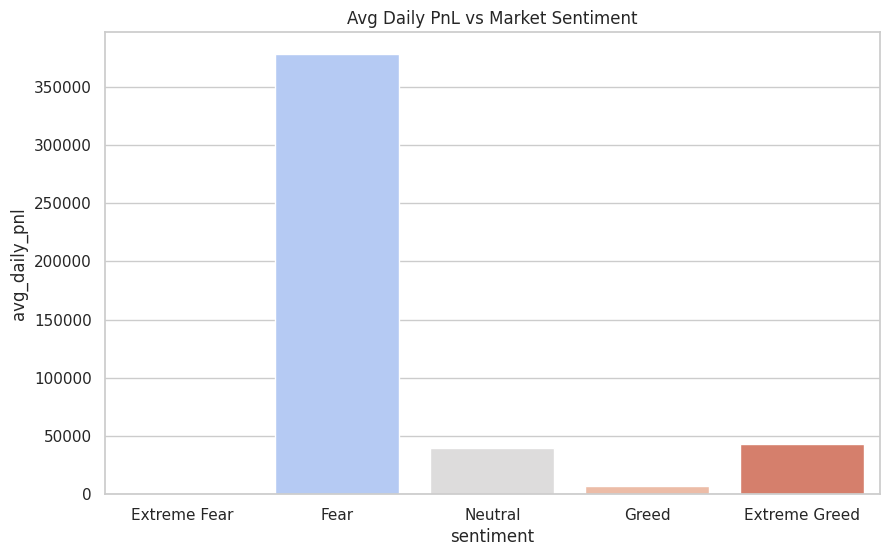

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=performance_summary.reset_index(), x='sentiment', y='avg_daily_pnl', ax=ax, palette='coolwarm')
ax.set_title('Avg Daily PnL vs Market Sentiment')
plt.show()

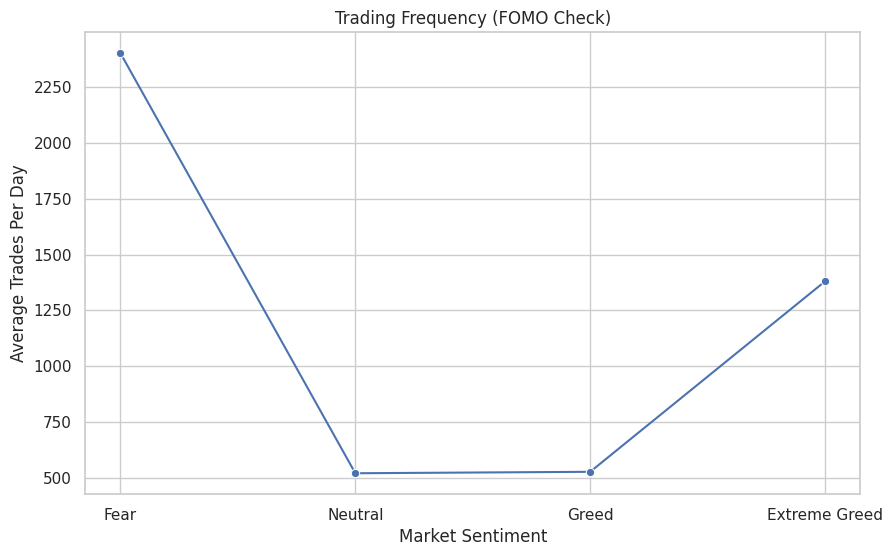

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=behavior_summary.reset_index(), x='sentiment', y='avg_trades_per_day', marker='o', ax=ax)
ax.set_title('Trading Frequency (FOMO Check)')
plt.ylabel('Average Trades Per Day')
plt.xlabel('Market Sentiment')
plt.show()

In [26]:
print("\n--- Performance Evidence ---")
print(performance_summary)
print("\n--- Behavioral Evidence ---")
print(behavior_summary)


--- Performance Evidence ---
               avg_daily_pnl  avg_win_rate  pnl_volatility  sample_size
sentiment                                                              
Extreme Fear             NaN           NaN             NaN          NaN
Fear           377839.118800      0.416011   594753.034281          9.0
Neutral         39857.368252      0.483342    92462.009746          3.0
Greed            7063.433020      0.316828   128953.041842         10.0
Extreme Greed   43429.001378      0.342032    96335.483165          4.0

--- Behavioral Evidence ---
               avg_trades_per_day  avg_position_size  avg_long_bias
sentiment                                                          
Extreme Fear                  NaN                NaN            NaN
Fear                  2400.777778        9607.736319       0.504216
Neutral                521.333333        3995.062697       0.350464
Greed                  527.800000        7065.800072       0.435256
Extreme Greed         1380.00

In [27]:
def get_actionable_recommendation(row):
    if row['sentiment'] in ['Greed', 'Extreme Greed'] and row['trades_per_day'] > 10:
        return "REDUCE LEVERAGE: FOMO detected."
    if row['sentiment'] == 'Extreme Fear' and row['daily_pnl'] > 0:
        return "INCREASE STOP-LOSS: High skill detected in panic."
    return "Neutral"

final_data['recommendation'] = final_data.apply(get_actionable_recommendation, axis=1)

In [28]:
ml_data = final_data.dropna(subset=['sentiment']).copy()
ml_data['sentiment_enc'] = LabelEncoder().fit_transform(ml_data['sentiment'])

X = ml_data[['sentiment_enc', 'trades_per_day', 'avg_trade_size', 'long_ratio']]
y = (ml_data['daily_pnl'] > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

print(f"Prediction Accuracy: {model.score(X_test, y_test):.2f}")

Prediction Accuracy: 0.50


In [29]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(trader_profiles[['avg_activity', 'avg_win_rate', 'total_pnl']])
trader_profiles['cluster'] = KMeans(n_clusters=3, random_state=42).fit_predict(scaled_features)

In [31]:
trader_profiles['archetype'] = trader_profiles['cluster'].map({0: "Passive", 1: "Scalpers", 2: "Whales"})

print("\n--- Final Analysis Data Sample ---")
print(final_data[['Account', 'sentiment', 'recommendation']].head())


--- Final Analysis Data Sample ---
                                      Account      sentiment  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012          Greed   
1  0x083384f897ee0f19899168e3b1bec365f52a9012           Fear   
2  0x420ab45e0bd8863569a5efbb9c05d91f40624641          Greed   
3  0x420ab45e0bd8863569a5efbb9c05d91f40624641           Fear   
4  0x430f09841d65beb3f27765503d0f850b8bce7713  Extreme Greed   

                    recommendation  
0  REDUCE LEVERAGE: FOMO detected.  
1                          Neutral  
2  REDUCE LEVERAGE: FOMO detected.  
3                          Neutral  
4  REDUCE LEVERAGE: FOMO detected.  
